
## Trial to combine middle ear and bruxism tagging to identify pure moments of middle ear activation

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')

In [6]:
import numpy as np
import mne
from tinnsleep.reports import combine_brux_MEMA, generate_bruxism_report, generate_MEMA_report
from tinnsleep.data import CreateRaw, CleanAnnotations, AnnotateRaw_sliding
from tinnsleep.events.scoring import classif_to_burst, burst_to_episode, episodes_to_list
from tinnsleep.utils import merge_labels_list
import warnings
import matplotlib.pyplot as plt
%matplotlib qt
import pandas as pd
from tinnsleep.config import Config
import scipy.stats
print("Config loaded")


Config loaded


## Loading parameters and results

In [18]:


# change to --overwrite True if you want to force to recompute the results
#%run ../compute_results.py --bruxism True --mema True --overwrite False 

#mema_files= pd.read_csv("data/mema_files.csv",engine='python', sep=", ")["files_with_mema"].values

results_MEMA = pd.read_pickle("data/reports_and_datas_MEMA.pk").to_dict()
results_brux = pd.read_pickle("data/reports_and_datas_bruxism.pk").to_dict()
min_burst_joining_brux = 3 
min_burst_joining_MEMA = 0
EDF_list = Config.bruxisme_files
print(EDF_list)
print(results_brux.keys())
print(results_MEMA.keys())

['F:/Acou_sommeil/EDF_recalcul\\1AC26_cohort2.edf', 'F:/Acou_sommeil/EDF_recalcul\\1BA07_nuit_hab.edf', 'F:/Acou_sommeil/EDF_recalcul\\1BA07_nuit_son.edf', 'F:/Acou_sommeil/EDF_recalcul\\1CB23_cohort2.edf', 'F:/Acou_sommeil/EDF_recalcul\\1CC05_nuit_hab.edf', 'F:/Acou_sommeil/EDF_recalcul\\1CC05_nuit_son.edf', 'F:/Acou_sommeil/EDF_recalcul\\1DA15_nuit_hab.edf', 'F:/Acou_sommeil/EDF_recalcul\\1DA15_nuit_son.edf', 'F:/Acou_sommeil/EDF_recalcul\\1DL12_nuit_hab.edf', 'F:/Acou_sommeil/EDF_recalcul\\1DL12_nuit_son.edf', 'F:/Acou_sommeil/EDF_recalcul\\1DM32_cohort2.edf', 'F:/Acou_sommeil/EDF_recalcul\\1GB18_nuit_hab.edf', 'F:/Acou_sommeil/EDF_recalcul\\1GB18_nuit_son.edf', 'F:/Acou_sommeil/EDF_recalcul\\1GF14_cohort2.edf', 'F:/Acou_sommeil/EDF_recalcul\\1GF14_nuit_hab.edf', 'F:/Acou_sommeil/EDF_recalcul\\1GF14_nuit_son.edf', 'F:/Acou_sommeil/EDF_recalcul\\1HB20_nuit_1.edf', 'F:/Acou_sommeil/EDF_recalcul\\1HB20_nuit_1_resmed.edf', 'F:/Acou_sommeil/EDF_recalcul\\1HB20_nuit_2.edf', 'F:/Acou_somme

## Bruxism + MEMA processing for pure MEMA visualisation

In [20]:
from time import time
# load file from config

ind_THR_brux=0
ind_THR_MEMA = 0

start = time()
results_brux_combine={}
results_brux_pure={}
results_MEMA_combine={}
results_MEMA_pure={}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    print("Files processed : ")
    
    #Loop on all the patient files
    for filename in EDF_list[:1]:
        
        #Tester si le fichier has left
        
        #opens the raw file
        file = filename.split(os.path.sep)[-1]
        
        
        if (list(results_MEMA.keys()).__contains__(file+"_left")):
            if file ==  "1HB20_nuit_1.edf" or file ==  "1UC22_nuit_1.edf" or file ==  "1SL21_nuit_2.edf"  or file ==  "1HB20_nuit_2.edf" or file ==  "1UC22_nuit_2.edf" or file ==  "1SL21_nuit_3.edf":
                file_sides=[file, file+"_left"]
            else:
               
                    file_sides=[file+"_right", file+"_left", file+"_right"] 
        else:
                file_sides=[file]
            
            
        print(file, end=" ")
        if not (file in results_brux.keys() and file in results_MEMA.keys()):
            #print(results_brux[file]["parameters"]["time_interval"])
            print(f"(does not have both bruxism and mema)... skipping")
        else:
            for file_side in file_sides:
                window_length_brux = results_brux[file]["parameters"]["time_interval"]
                delim_brux = results_brux[file]["parameters"]["delim"]
                window_length_MEMA = results_MEMA[file]["parameters"]["time_interval"]
                delim_MEMA = results_MEMA[file]["parameters"]["delim"]
                params_combine = dict(
                                    labels_brux = results_brux[file]["labels"][ind_THR_brux], 
                                    time_interval_brux = results_brux[file]["parameters"]["time_interval"], 
                                    delim_ep_brux = results_brux[file]["parameters"]["delim"], 
                                    labels_MEMA = results_MEMA[file_side]["labels"][ind_THR_MEMA], #droite ou gauche
                                    time_interval_MEMA = results_MEMA[file]["parameters"]["time_interval"],
                                    delim_ep_MEMA = results_brux[file]["parameters"]["delim"],
                                    min_burst_joining_brux=min_burst_joining_brux, 
                                    min_burst_joining_MEMA=min_burst_joining_MEMA
                                    )
                print(results_MEMA[file_side]["parameters"]["time_interval"])
                print(len(results_brux[file]["labels"][0]))
                print(np.sum(results_brux[file]["labels"][0]))
                print(results_brux[file]["reports"][0])
                print(len(results_MEMA[file_side]["labels"][0])*4)
                print(results_brux[file]["parameters"]["time_interval"])
                print(results_MEMA[file]["reports"][0])

                brux_comb_ep, brux_pure_ep, MEMA_comb_ep, MEMA_pure_ep = combine_brux_MEMA(**params_combine)
                valid_labels_MEMA= results_MEMA[file_side]["parameters"]["valid_labels"]
                valid_labels_brux= results_brux[file]["parameters"]["valid_labels"]
                #LIGNE IMPORTANTE A CONSERVER
                valid_labels_MEMA = merge_labels_list([valid_labels_MEMA], len(valid_labels_brux))


                results_brux_combine[file_side]= { "THR_classif": [results_brux[file]["THR_classif"][ind_THR_brux]],
                     "labels":  [brux_comb_ep]     ,              
                    "reports": [generate_bruxism_report(brux_comb_ep, window_length_brux, delim_brux, valid_labels= valid_labels_brux, min_burst_joining=0)]
                    }

                results_brux_pure[file_side]= { "THR_classif": [results_brux[file]["THR_classif"][ind_THR_brux]],
                     "labels":  [brux_pure_ep]     ,              
                    "reports": [generate_bruxism_report(brux_pure_ep, window_length_brux, delim_brux, valid_labels= valid_labels_brux, min_burst_joining=0)]
                    }


                results_MEMA_combine[file_side]= { "THR_classif": [results_MEMA[file]["THR_classif"][ind_THR_brux]],
                     "labels":  [MEMA_comb_ep]     ,              
                    "reports": [generate_MEMA_report(MEMA_comb_ep, window_length_brux, delim_MEMA, valid_labels= valid_labels_MEMA)]}

                results_MEMA_pure[file_side]= { "THR_classif": [results_MEMA[file]["THR_classif"][ind_THR_brux]],
                     "labels": [ MEMA_pure_ep  ]   ,              
                    "reports": [generate_MEMA_report(MEMA_pure_ep, window_length_brux, delim_MEMA, valid_labels= valid_labels_MEMA)]}

                print("heu")
                print(len(MEMA_comb_ep))
                print(np.sum(brux_comb_ep))
                print(np.sum(brux_pure_ep))
                print(window_length_brux)
                print(delim_brux)
                print(min_burst_joining_brux)

                pure_brux_bursts = classif_to_burst(brux_pure_ep, time_interval=window_length_brux)
                li_ep_brux_p = burst_to_episode(pure_brux_bursts, delim=delim_brux, min_burst_joining= 0)#important!!
                pure_brux_events = episodes_to_list(li_ep_brux_p, window_length_brux, len(brux_pure_ep))

                comb_brux_bursts = classif_to_burst(brux_comb_ep, time_interval=window_length_brux)
                li_ep_brux_c = burst_to_episode(comb_brux_bursts, delim=delim_brux, min_burst_joining= 0) #Important!!
                comb_brux_events = episodes_to_list(li_ep_brux_c, window_length_brux, len(brux_comb_ep))

                comb_MEMA_bursts = classif_to_burst(MEMA_comb_ep, time_interval=window_length_brux) # window_length_brux is valid ?

                pure_MEMA_bursts = classif_to_burst(MEMA_pure_ep, time_interval=window_length_brux) # window_length_brux is valid ?

                print("rapport d'activité : ")
                print("nb episodes bruxisme combinés : ")
                print(len(li_ep_brux_c))
                print("Nb épisodes bruxisme purs : ")
                print(len(li_ep_brux_p))
                print("nb episodes MEMA combinés : ")
                print(len(comb_MEMA_bursts))
                print("Nb épisodes MEMA purs : ")
                print(len(pure_MEMA_bursts))


                print("rapport d'activité taux horaire : ")
                print("nb episodes bruxisme combinés : ")
                print(len(li_ep_brux_c)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
                print("Nb épisodes bruxisme purs : ")
                print(len(li_ep_brux_p)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
                print("nb episodes MEMA combinés : ")
                print(len(comb_MEMA_bursts)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
                print("Nb épisodes MEMA purs : ")
                print(len(pure_MEMA_bursts)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))

                new_l_comb=[]
                for i in range(len(MEMA_comb_ep)):
                    if MEMA_comb_ep[i]:
                        new_l_comb.append(3)
                    else:
                        new_l_comb.append(0)

                new_l_pure=[]
                for i in range(len(MEMA_pure_ep)):
                    if MEMA_pure_ep[i]:
                        new_l_pure.append(2)
                    else:
                        new_l_pure.append(0)

                for i in range(len(comb_brux_events)):
                    if comb_brux_events[i]>0:
                        comb_brux_events[i]=4

                for i in range(len(pure_brux_events)):
                    if pure_brux_events[i]>0:
                        pure_brux_events[i]=5

                plt.figure()
                plt.plot(pure_brux_events, label="pure_brux")
                plt.plot(comb_brux_events, label="comb_brux")
                plt.plot(new_l_comb, label="comb_MEMA")
                plt.plot(new_l_pure, label="pure_MEMA")
                plt.legend()
                plt.title("Where the events happen for " + file_side)


pd.DataFrame.from_dict(results_brux_combine).to_pickle("data/reports_and_datas_bruxism_combine.pk", protocol=3)
pd.DataFrame.from_dict(results_brux_pure).to_pickle("data/reports_and_datas_bruxism_pure.pk", protocol=3)
pd.DataFrame.from_dict(results_MEMA_combine).to_pickle("data/reports_and_datas_MEMA_combine.pk", protocol=3)
pd.DataFrame.from_dict(results_MEMA_pure).to_pickle("data/reports_and_datas_MEMA_pure.pk", protocol=3)
print("results saved!!")

Files processed : 
1AC26_cohort2.edf 0.992
139032
3347
{'Clean data duration': 23530.736, 'Total burst duration': 830.056, 'Total number of burst': 1311, 'Number of bursts per hour': 200.57171182405853, 'bruxism episode NREM count': 113, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 113, 'Number of bursts per episode': 11.601769911504425, 'Number of episodes per hour': 17.28802702983876, 'Number of tonic episodes per hour': 2.7538450136026342, 'Number of phasic episodes per hour': 2.352395607175228, 'Number of mixed episodes per hour': 1.252081532851331, 'Mean duration of tonic episode': 5.7728888888891055, 'Mean duration of phasic episode': 5.484000000000158, 'Mean duration of mixed episode': 15.195636363636588, 'End count': 28, 'End ratio': 0.00020139248518326715, 'NREM count': 97135, 'NREM ratio': 0.6986521088670234, 'Wake count': 41780, 'Wake ratio': 0.3005063582484608, 'start count': 89, 'start ratio': 0.0006401403993325277, 'Power Ratio': array([14.28161079, 13.9

heu
139032
1833
1979
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
55
Nb épisodes bruxisme purs : 
58
nb episodes MEMA combinés : 
57
Nb épisodes MEMA purs : 
101
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
5.742470055628874
Nb épisodes bruxisme purs : 
6.055695695026812
nb episodes MEMA combinés : 
5.951287148560833
Nb épisodes MEMA purs : 
10.545263193063931
0.992
139032
3347
{'Clean data duration': 23530.736, 'Total burst duration': 830.056, 'Total number of burst': 1311, 'Number of bursts per hour': 200.57171182405853, 'bruxism episode NREM count': 113, 'bruxism episode NREM ratio': 1.0, 'Total number of episodes': 113, 'Number of bursts per episode': 11.601769911504425, 'Number of episodes per hour': 17.28802702983876, 'Number of tonic episodes per hour': 2.7538450136026342, 'Number of phasic episodes per hour': 2.352395607175228, 'Number of mixed episodes per hour': 1.252081532851331, 'Mean duration of tonic episode': 5.7728888888891055,

       8.53105299e-05]), array([36, 64, 78, 78, 78], dtype=int64), array([ 78,  78, 169, 231, 247], dtype=int64))], [(array([ 61, 156, 186], dtype=int64), {}), (array([0.25827277, 0.01393483, 0.00690397]), array([  2, 149, 180], dtype=int64), array([247, 247, 247], dtype=int64))], [(array([157, 222, 243], dtype=int64), {}), (array([0.02523319, 0.03882246, 0.00679003]), array([ 22,  22, 235], dtype=int64), array([168, 235, 247], dtype=int64))], [(array([ 70, 117], dtype=int64), {}), (array([1.20629023, 0.07665558]), array([20, 95], dtype=int64), array([247, 247], dtype=int64))], [(array([ 2, 42, 61, 93], dtype=int64), {}), (array([0.00155503, 0.00334685, 0.00854915, 0.00075245]), array([ 0, 35, 53, 89], dtype=int64), array([247, 247, 247, 247], dtype=int64))], [(array([19, 64], dtype=int64), {}), (array([0.00286966, 0.00741063]), array([13, 57], dtype=int64), array([75, 75], dtype=int64))]]}
heu
139032
1217
2595
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
30
Nb épis

heu
139032
1833
1979
0.248
3
3
rapport d'activité : 
nb episodes bruxisme combinés : 
55
Nb épisodes bruxisme purs : 
58
nb episodes MEMA combinés : 
57
Nb épisodes MEMA purs : 
101
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
5.742470055628874
Nb épisodes bruxisme purs : 
6.055695695026812
nb episodes MEMA combinés : 
5.951287148560833
Nb épisodes MEMA purs : 
10.545263193063931
results saved!!


## Display of the last computed recording

In [25]:

raw  = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading
duration_brux = int(results_brux[file]["parameters"]["time_interval"] * raw.info['sfreq'])  
interval_brux=duration_brux
print(duration_brux)

print(raw.info["ch_names"])

#print(len(raw))
#-----------------Pure MEMA episodes visualisation and comparison with ATM activity -----------------------------------
#Preparing raw for visualisation
picks_chan = ['Mask Pressure', 'Pression diff', '1', '2', "Activity"]           # subset of EMG electrodes

print(raw.info["sfreq"])

raw  = CreateRaw(raw[picks_chan][0], raw.info["sfreq"], picks_chan, ch_types=['misc','misc','emg','emg', "misc"])        # pick channels and load
print(len(raw))
scalings = dict(misc=1, emg=1e-5)

raw  = raw.filter(20., 99., n_jobs=4, 
                  fir_design='firwin', filter_length='auto', phase='zero-double',
                  picks=['1', '2'])
raw  = raw.filter(0.25, 16., n_jobs=4, 
                  fir_design='firwin', filter_length='auto', phase='zero-double',
                  picks=['Mask Pressure', 'Pression diff'])
#Annotating the raw
raw = CleanAnnotations(raw)
dict_annotations = {1: "b_pure", 2:"M_pure", 3:"M_comb", 4:"b_comb"}
#raw = AnnotateRaw_sliding(raw, results_brux[file]["labels"][ind_THR_brux][1:-1] , 
#                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)
raw = AnnotateRaw_sliding(raw, new_l_pure[1:-1] , 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)

raw = AnnotateRaw_sliding(raw,  pure_brux_events[1:-1], 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)
raw = AnnotateRaw_sliding(raw, comb_brux_events[1:-1] , 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)
raw = AnnotateRaw_sliding(raw, new_l_comb[1:-1], 
                dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux, merge=True)


print("Raw annotated")
scalings = {'emg': 5e-5, 'misc': 0.2, 'bio':1e3}
raw.plot(scalings = scalings)
plt.title(filename)

<ipython-input-25-558ee95b2488>:1: RuntimeWarning: 7 channel names are too long, have been truncated to 15 characters:
['Inductance Abdom', 'Inductance Thora', 'Intensit? lumine', 'Jambe droite Imp', 'Jambe gauche Imp', 'Tension (aliment', 'Tension (Bluetoo']
  raw  = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading


62
['1', '1 Imp?dance', '1-2', '1-2 (Imp)', '1-F', '1-F (Imp)', '2', '2 Imp?dance', '2-F', 'Abdomen CaL', 'Abdomen', 'Activity', 'Audio Volume dB', 'X Axis', 'Y Axis', 'Z Axis', 'C3', 'C3 Imp?dance', 'C3-M2', 'C3-M2 (Imp)', 'C4', 'C4 Imp?dance', 'C4-M1', 'C4-M1 (Imp)', 'cRIP Flow', 'cRIP Sum', 'E1', 'E1 Imp?dance', 'E1-M2', 'E1-M2 (Imp)', 'E2', 'E2 Imp?dance', 'E2-M1', 'E2-M1 (Imp)', 'ECG', 'ECG Imp?dance', 'Elevation', 'F', 'F Imp?dance', 'F3', 'F3 Imp?dance', 'F3-M2', 'F3-M2 (Imp)', 'F4', 'F4 Imp?dance', 'F4-M1', 'F4-M1 (Imp)', 'Heart Rate', 'Inductance Abdo', 'Inductance Thor', 'Light', 'Intensit? lumin', 'Right Leg', 'Jambe droite Im', 'Left Leg', 'Jambe gauche Im', 'K', 'M1', 'M1 Imp?dance', 'M1M2', 'M2', 'M2 Imp?dance', 'O1', 'O1 Imp?dance', 'O1-M2', 'O1-M2 (Imp)', 'O2', 'O2 Imp?dance', 'O2-M1', 'O2-M1 (Imp)', 'Pulse Waveform', 'PosAngle', 'Pulse', 'Pression diff', 'Mask Pressure', 'PTT', 'PWA', 'Resp Rate', 'RIP Flow', 'RIP Phase', 'RIP Sum', 'MaskPressure', 'Saturation', 'SpO2 

Text(0.5, 1.0, 'F:/Acou_sommeil/EDF_recalcul\\1AC26_cohort2.edf')

Channels marked as bad: none


## Analysis 

In [10]:
from tinnsleep.data import read_etiology_file
etiology_file = "data/etiology.xlsx"
#Here replace with the metric to analyse
info_file = "data/data_info.csv"
results_file = "data/reports_and_datas_MEMA_pure.pk"
results = pd.read_pickle(results_file).to_dict()
THR_classif = np.array(results[list(results.keys())[0]]["THR_classif"])

data_info = pd.read_csv(info_file, sep=";").query('mema == 1 & emg == 1 & included == 1 & session == "1" & Right_ears != "0" ')
#print(data_info["Controlateral"])
etiology = read_etiology_file(etiology_file)
data_info = data_info.merge(etiology,on="subject")
#print(data_info.keys())
#data_info = pd.read_csv(info_file, sep=";").query('mema == 1 & included == 1 & subject == "1SL21" & session != "6" ')

print(f"Valid files for mema {data_info.shape[0]}")
print(data_info[["filename", "subject", "mema", "emg", "condition", "neck_pain", "Ear_select"]])

# keep only results from query
#results= {filename:results[filename] for filename in data_info["Ear_select"].values}
#results= {filename:results[filename] for filename in data_info["filename"].values}
#results= {filename:results[filename] for filename in data_info["Controlateral"].values}
results= {filename:results[filename] for filename in data_info["Right_ears"].values}
print(results.keys())

Valid files for mema 22
              filename subject  mema  emg    condition  neck_pain  \
0   1DA15_nuit_hab.edf   1DA15     1    1  habituation       True   
1   1GB18_nuit_hab.edf   1GB18     1    1  habituation      False   
2     1HB20_nuit_1.edf   1HB20     1    1  habituation       True   
3     1SL21_nuit_2.edf   1SL21     1    1  habituation      False   
4     1UC22_nuit_1.edf   1UC22     1    1  habituation      False   
5     2SJ03_nuit_1.edf   2SJ03     1    1      control      False   
6     2LS05_nuit_1.edf   2LS05     1    1      control      False   
7     2CT04_nuit_1.edf   2CT04     1    1      control      False   
8    1ZN04_cohort2.edf   1ZN04     1    1       batch2      False   
9    1HS25_cohort2.edf   1HS25     1    1       batch2       True   
10   1PA31_cohort2.edf   1PA31     1    1       batch2       True   
11   3NS01_cohort2.edf   3NS01     1    1       batch2       True   
12   1RF29_cohort2.edf   1RF29     1    1       batch2       True   
13   1GF14

No handles with labels found to put in legend.


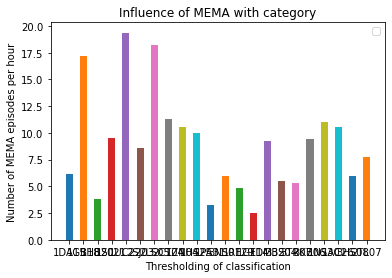

In [12]:
# visualization function
#plt.close("all")
plt.figure()
value = "Number of MEMA episodes per hour"
width = 0.5
for filename in results.keys():
    #print(results[filename]["reports"][0][value])
    plt.bar(filename[:5], results[filename]["reports"][0][value], width)
plt.title("Influence of MEMA with category" )
plt.xlabel('Thresholding of classification')
plt.ylabel(value)
#plt.tight_layout()
plt.legend()



In [13]:
# format reports
reports = None
for filename in results.keys():
    report = pd.DataFrame(results[filename]["reports"])
    report["THR_classif"] = THR_classif[:,1]
    report["filename"] = filename
    if reports is None:
        reports = report
    else:
        reports = reports.append(report, ignore_index=True)

        
import math     
def map_category(x):
    if x < (-0.1):
        return "decrease"
    elif x > (0.1):
        return "increase"
    elif math.isnan(x):
        return "control"
    else:
        return "stable"
#putting away damaged recordings
data_info["category"] = data_info["mask_delta"].apply(map_category)
#data_info["filename"] = data_info["Ear_select"]
#data_info["filename"] = data_info["Controlateral"]
data_info["filename"] = data_info["Right_ears"]

reports = reports.merge(data_info, on="filename")

In [14]:
##Preparing values for correlation scatter plots
    
print("Nb_patients in each group : ")
for category in list(data_info['category'].unique()):
    print(f"Tinnitus {category} : {(data_info['category']==category).sum()}, {(list(data_info[data_info['category']==category]['subject']))}")

report_mean = reports.groupby(['category', 'THR_classif']).mean()
report_std =  reports.groupby(['category', 'THR_classif']).std()

Nb_patients in each group : 
Tinnitus decrease : 9, ['1DA15', '1HB20', '1SL21', '1ZN04', '3NS01', '3BS04', '3TR07', '3KB06', '3HS08']
Tinnitus increase : 7, ['1GB18', '1UC22', '1HS25', '1GF14', '1DM32', '1NS30', '1AC26']
Tinnitus control : 4, ['2SJ03', '2LS05', '2CT04', '2TL07']
Tinnitus stable : 2, ['1PA31', '1RF29']


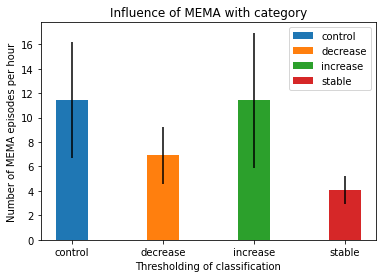

In [15]:
#Displaying
plt.figure()
value = "Number of MEMA episodes per hour"
width = 0.35
for category in list(report_mean.index.get_level_values(0).unique()):
    plt.bar(category, report_mean.loc[category][value], width, yerr = report_std.loc[category][value], label = category)
plt.title("Influence of MEMA with category" )
plt.xlabel('Thresholding of classification')
plt.ylabel(value)
plt.legend()

In [16]:
l=[]
for i in range(4):
    print(list(reports.groupby(['category', 'THR_classif']))[i][0])
    print(list(list(reports.groupby(['category', 'THR_classif']))[i][1]["Number of MEMA episodes per hour"]))
    l.append(list(list(reports.groupby(['category', 'THR_classif']))[i][1]["Number of MEMA episodes per hour"]))
print(scipy.stats.ttest_ind(l[0], l[2]))
print(scipy.stats.ttest_ind(l[1], l[2]))
print(scipy.stats.ttest_ind(l[3], l[2]))

('control', 3)
[8.551223252486269, 18.21346177196746, 11.2636446936352, 7.748133991063819]
('decrease', 3)
[6.116207951070336, 3.8172920065252853, 9.481191705608211, 10.552418490898013, 5.971984941999784, 5.508435894669577, 5.331047603119186, 9.403244176647807, 6.00861578278339]
('increase', 3)
[17.202137692549513, 19.367647180346022, 9.969868840836583, 2.5142799337523996, 9.2390992952501, 11.062014884555584, 10.545263193063931]
('stable', 3)
[3.262089060421696, 4.879348635921274]
Ttest_indResult(statistic=0.008988814507760515, pvalue=0.9930241567408251)
Ttest_indResult(statistic=-2.224067410891948, pvalue=0.04310808026030708)
Ttest_indResult(statistic=-1.7817659975467302, pvalue=0.11798993018630934)


In [17]:
quantitative_variables = list(results[list(results.keys())[0]]["reports"][0].keys()) #(remove power ratio a sleep analysis)
print(f'variables: {quantitative_variables}')
effect_variable = ["mask_delta", "mask_per", "VAS_I_delta", "VAS_I_per", "VAS_L_delta", "VAS_L_per"]
#reports["Power Ratio"] = reports["Power Ratio"].apply(sum)

variables: ['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode', 'Number of MEMA episodes per hour', 'Mean duration of MEMA episode']


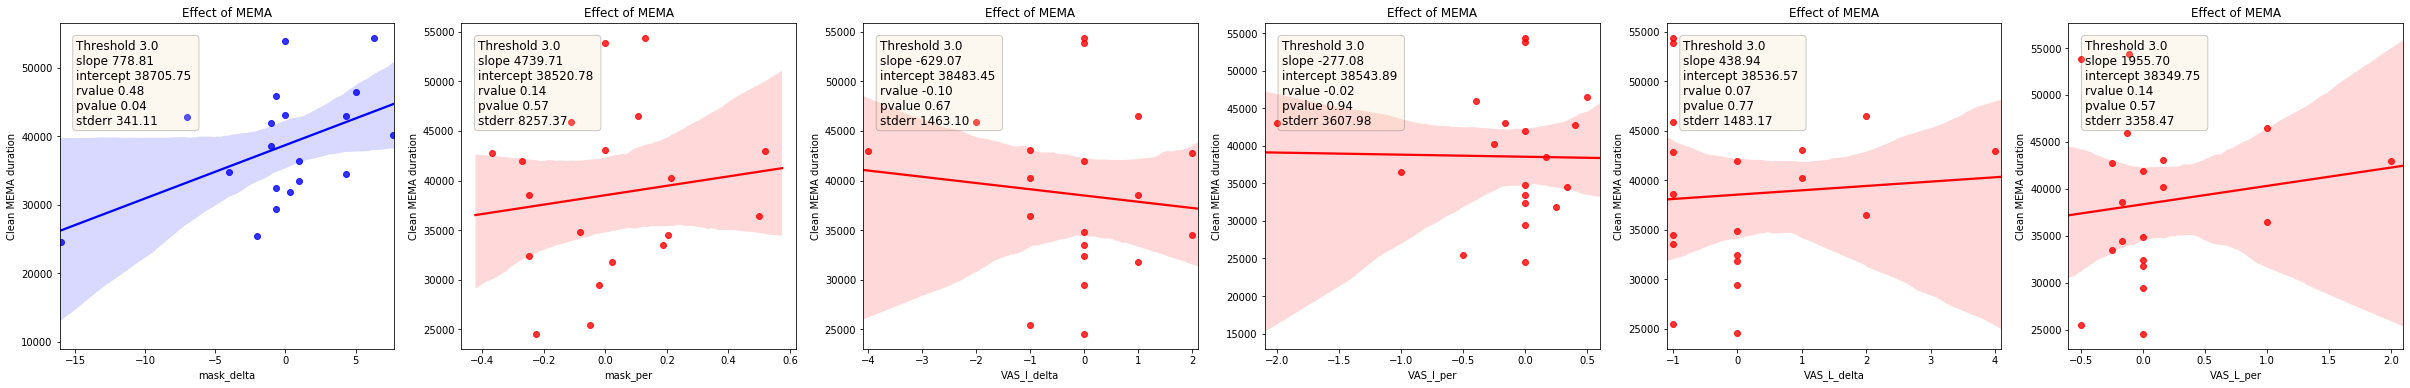

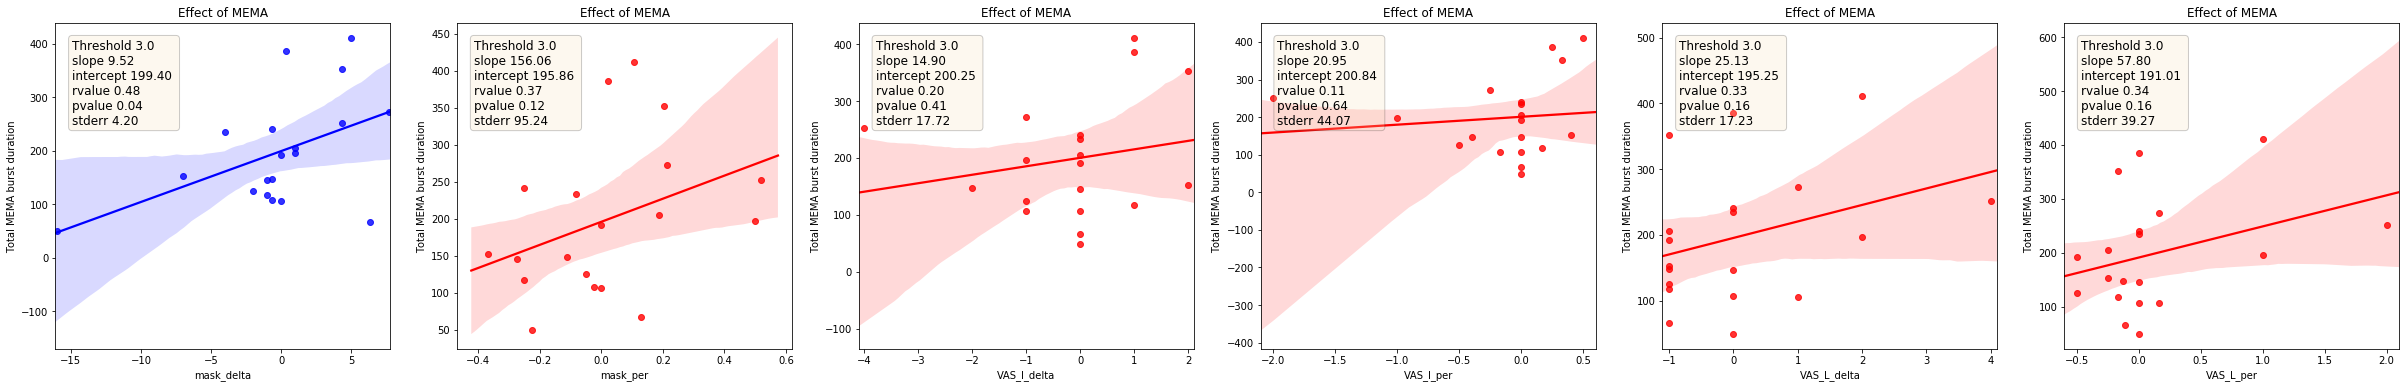

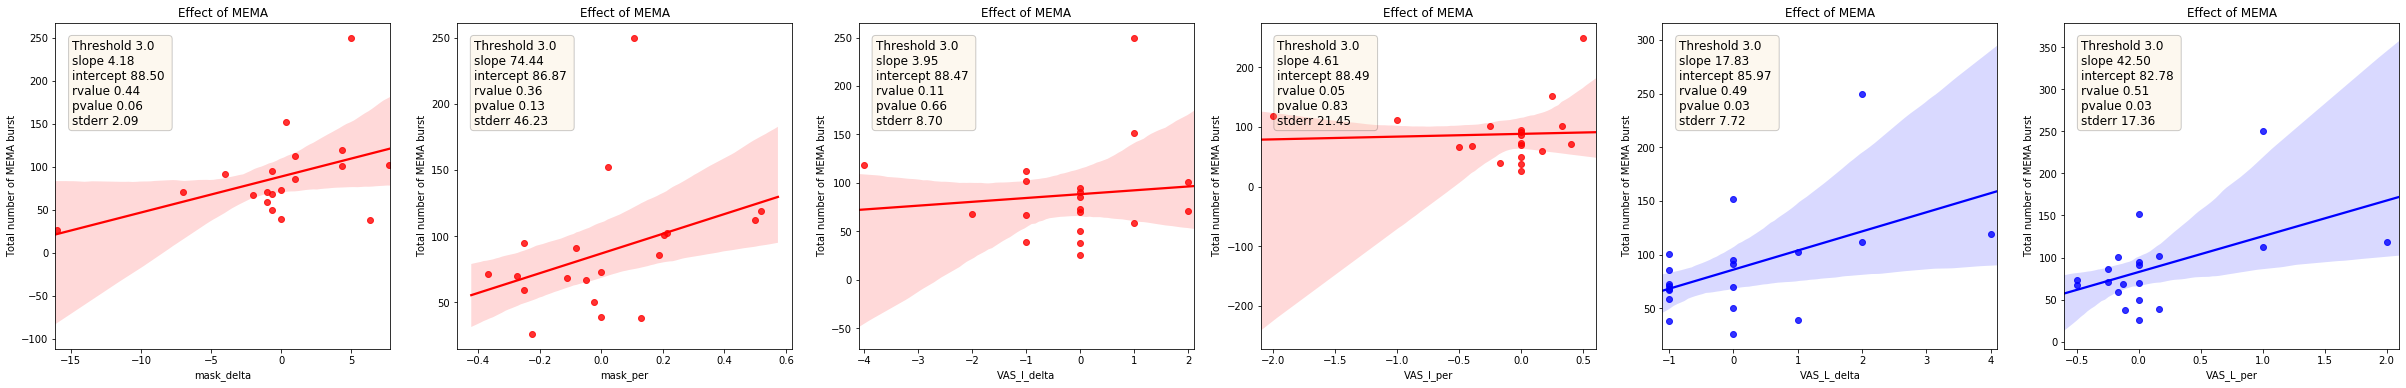

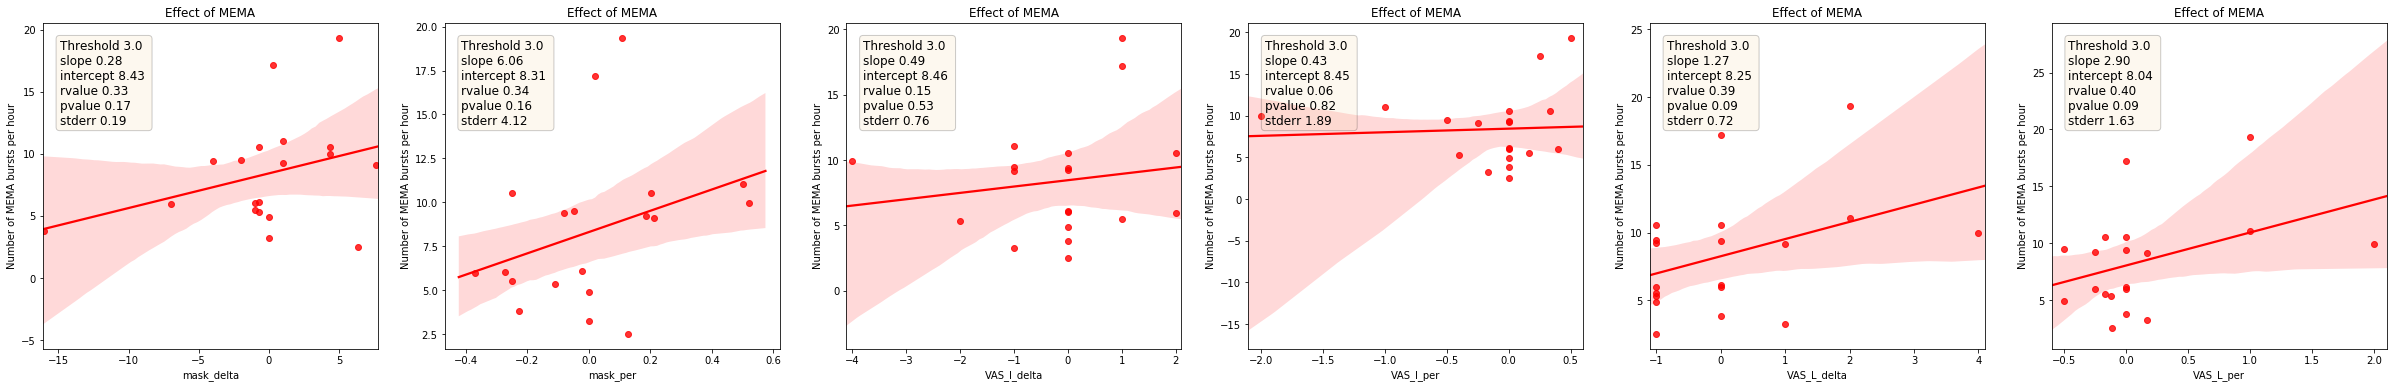

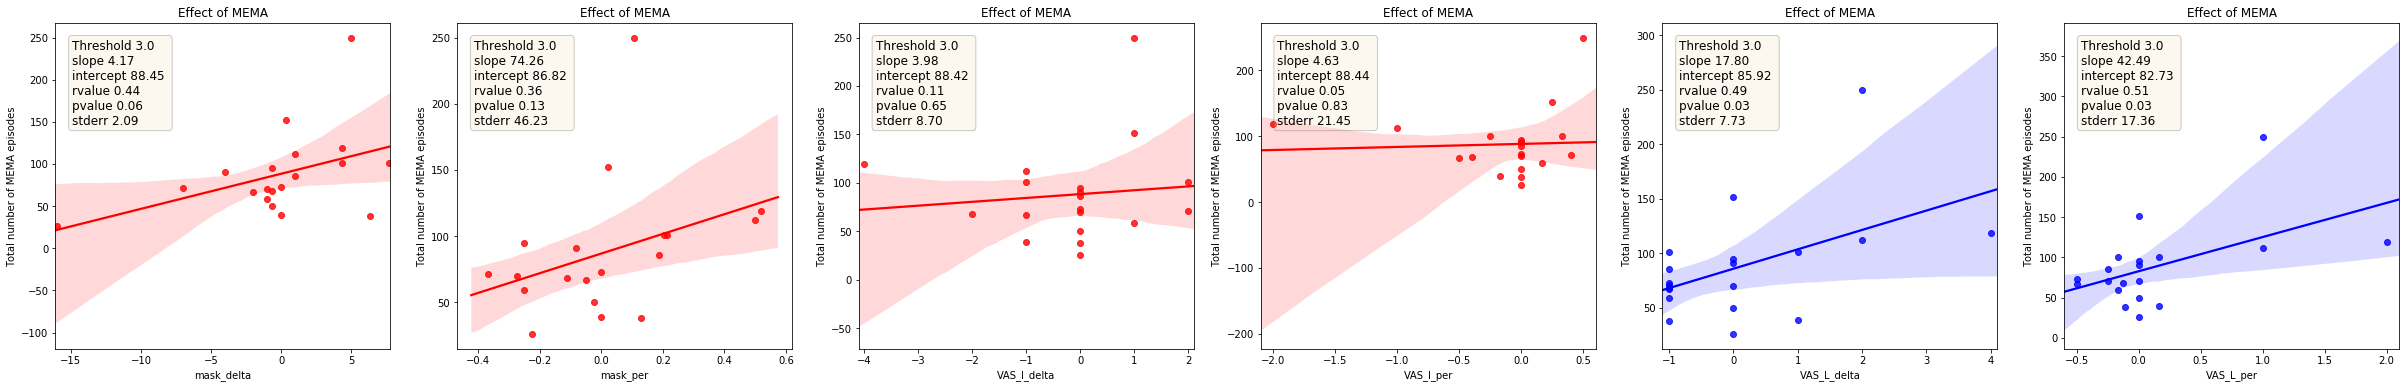

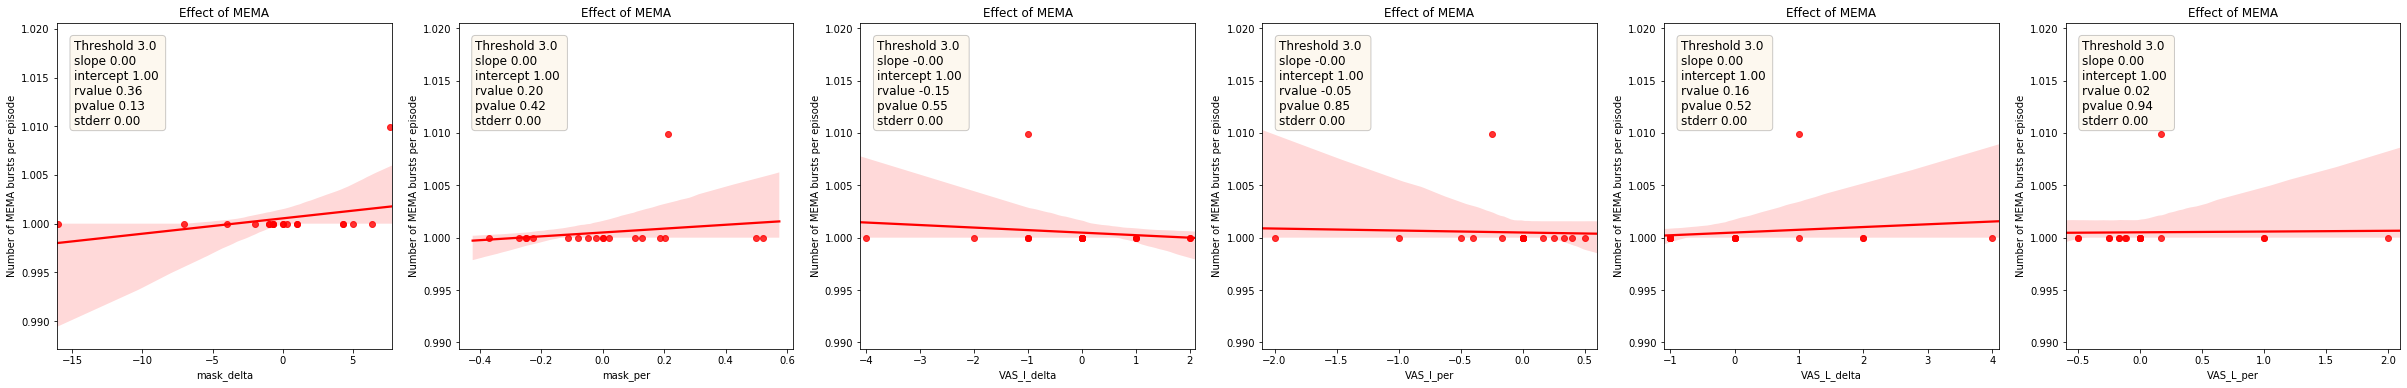

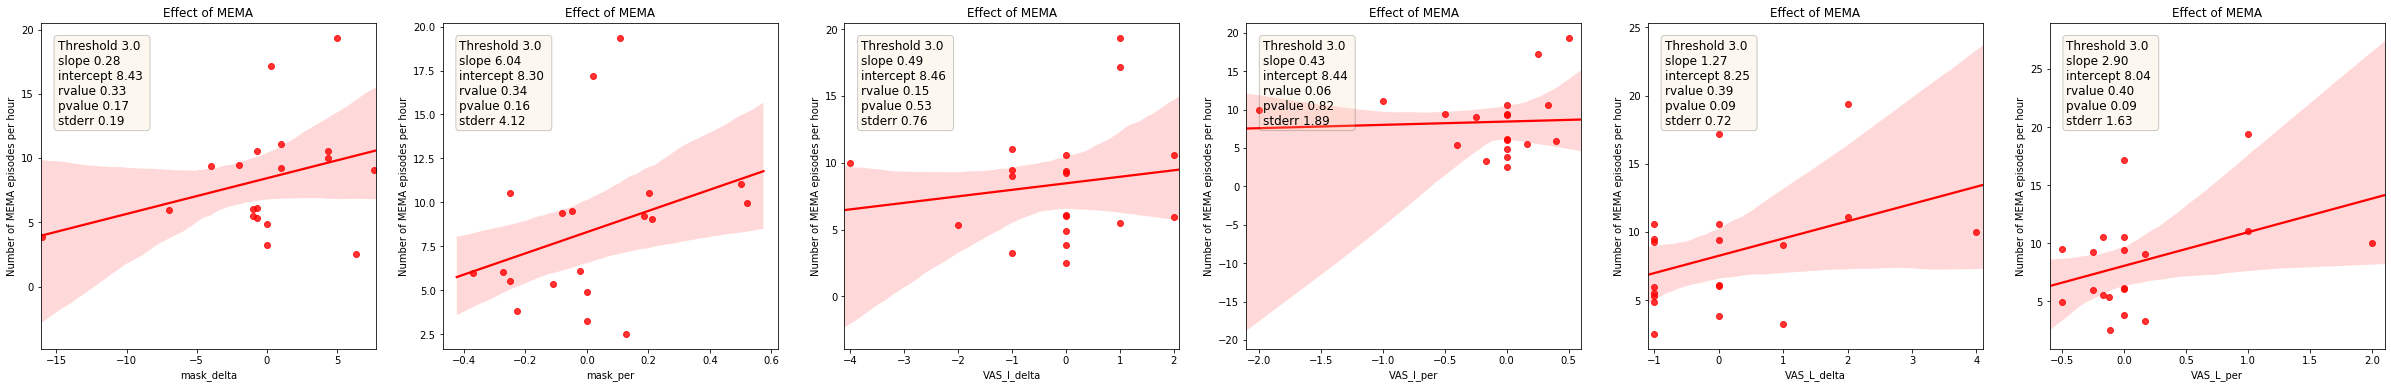

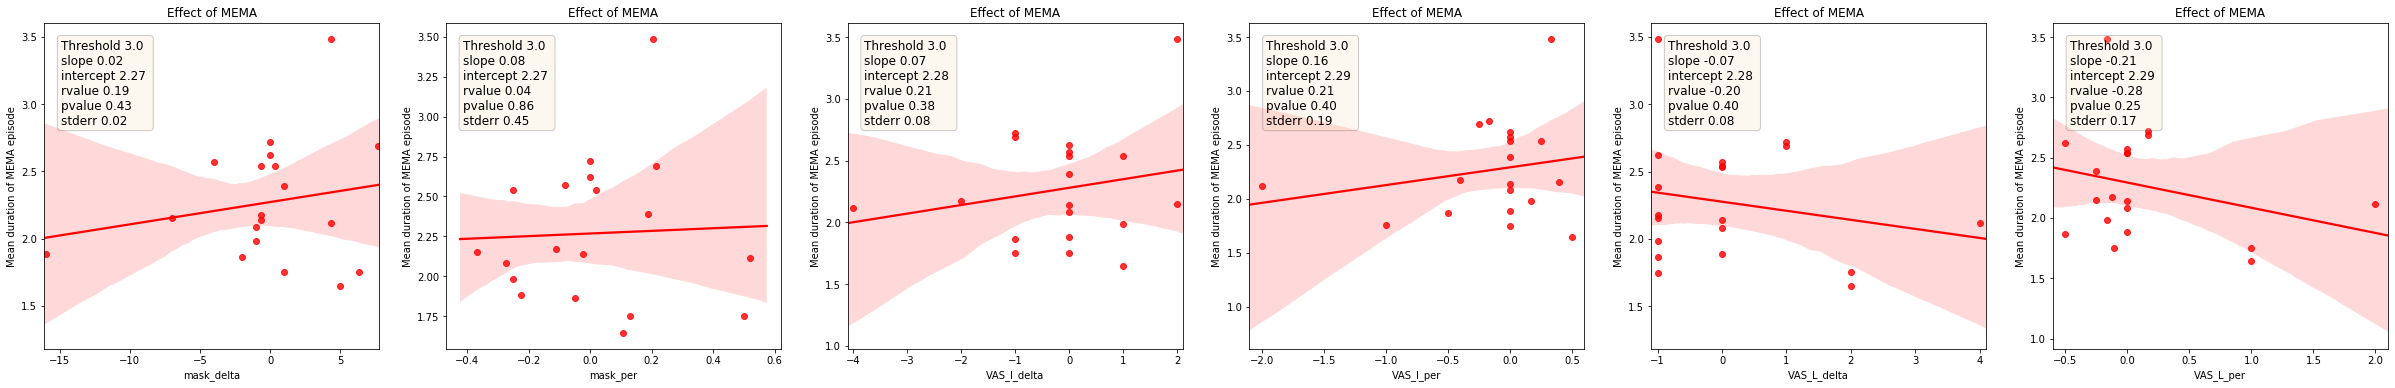

In [11]:
meta_results = pd.DataFrame()
import seaborn as sns
plt.close("all")
data = reports.query("category != 'control'")
# loop over all quantitative variables (y_axis)
for y_axis in quantitative_variables:
    # loop on all classification results (each figure)
    for threshold in reports["THR_classif"].unique():
        data_loc = data[data["THR_classif"]==threshold]
        f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 6))
        # loop on all effect variables (each subplot)
        for x_axis, ax in zip(effect_variable, axes):
            
            
            regression_result = scipy.stats.linregress(data_loc[x_axis].values,data_loc[y_axis].values)
            if regression_result.pvalue < 0.01:
                    color = 'g'
            elif regression_result.pvalue < 0.05:
                    color = 'b'
            else:
                    color = 'r'
            sns.regplot(x=x_axis,y=y_axis,data=data_loc,fit_reg=True, ax=ax,  color=color)
            ax.set_xlim(min(data_loc[x_axis].values)-0.1,max(data_loc[x_axis].values)+0.1)
            tmp = {"x_axis":x_axis, "y_axis":y_axis, "THR_classif": [threshold]}
            textstr = f"Threshold {threshold:.1f} "
            for a, re in zip(regression_result._fields, regression_result):
                textstr = textstr + "\n" + f"{a} {re:.2f} "
                tmp[a] = [re]
            ax.set_title("Effect of MEMA")
            # place patch
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                    verticalalignment='top', bbox=props)
            
            # save results
            meta_results = pd.concat([meta_results, pd.DataFrame(tmp)])

In [13]:
meta_results.query("pvalue < 0.05")

,x_axis,y_axis,THR_classif,slope,intercept,rvalue,pvalue,stderr
0,mask_delta,Clean MEMA duration,3,778.812036,38705.745900,0.484435,0.035561,341.110467
0,mask_delta,Total MEMA burst duration,3,9.522595,199.400831,0.481854,0.036700,4.199955
0,VAS_L_delta,Total number of MEMA burst,3,17.825545,85.965732,0.488390,0.033868,7.724660
0,VAS_L_per,Total number of MEMA burst,3,42.498016,82.778380,0.510469,0.025535,17.362847
0,VAS_L_delta,Total number of MEMA episodes,3,17.799065,85.915888,0.487813,0.034111,7.725168
0,VAS_L_per,Total number of MEMA episodes,3,42.490700,82.726620,0.510536,0.025513,17.356760


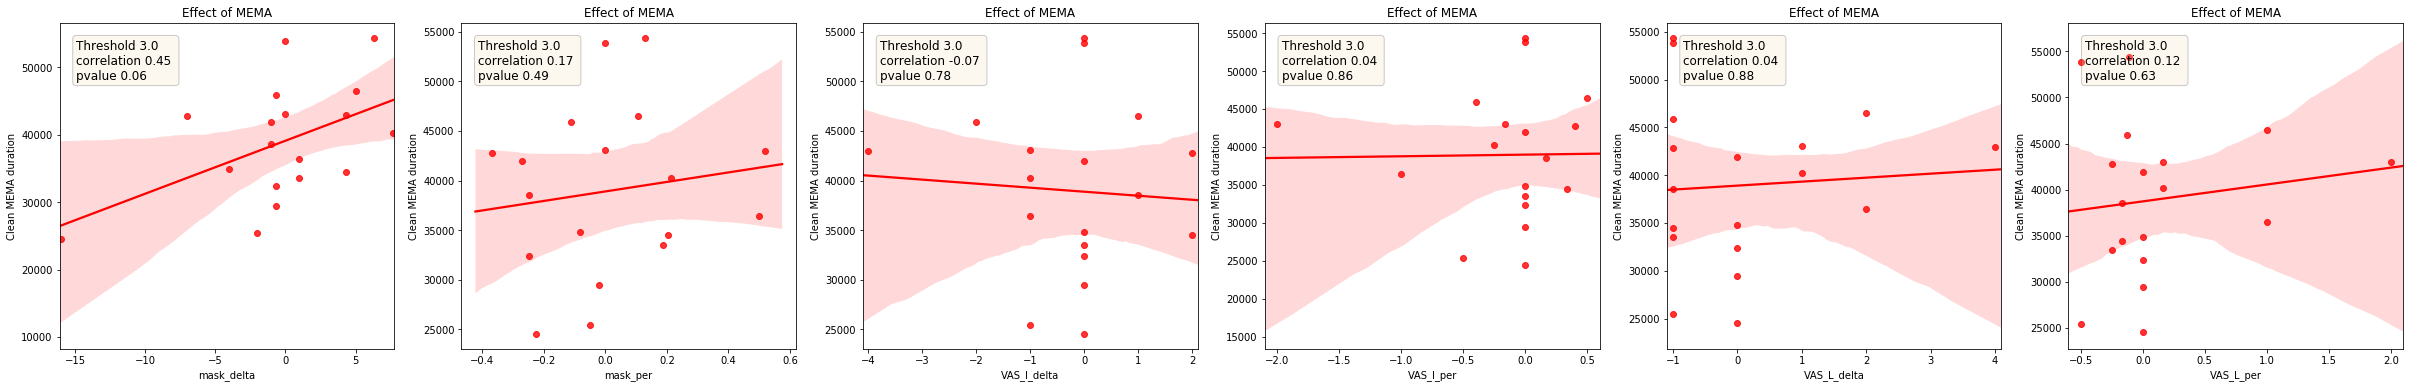

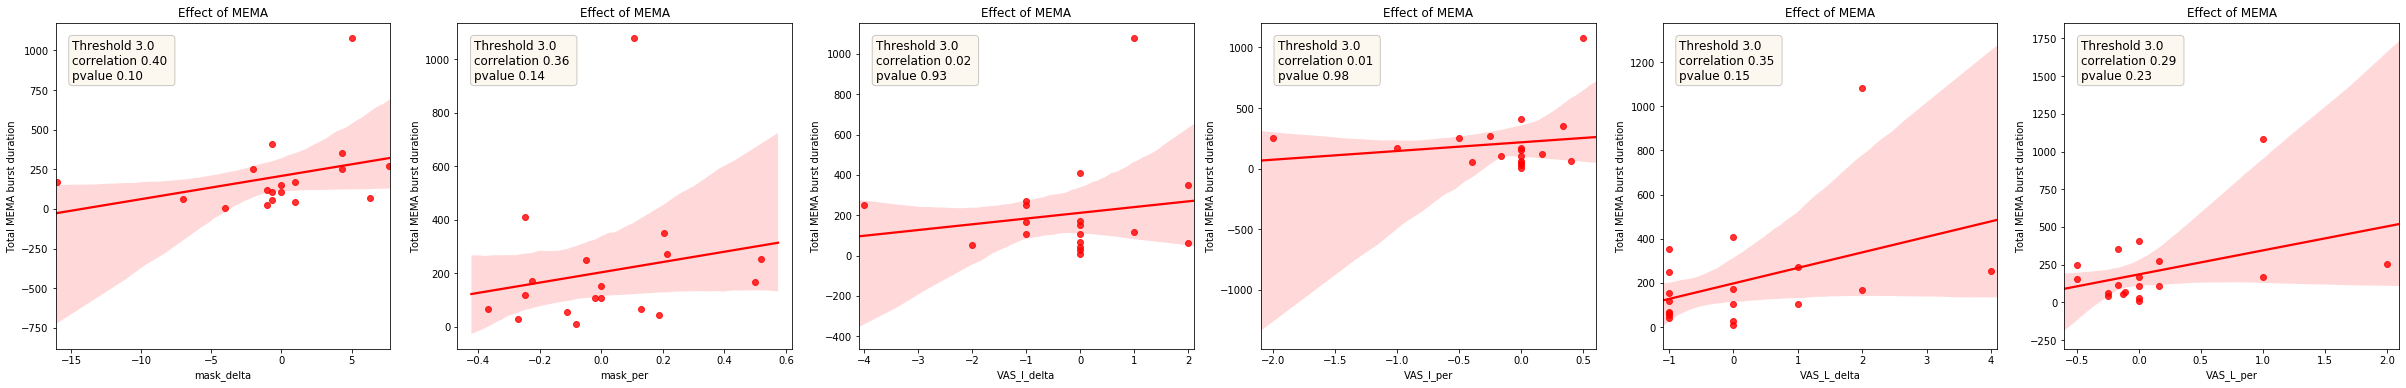

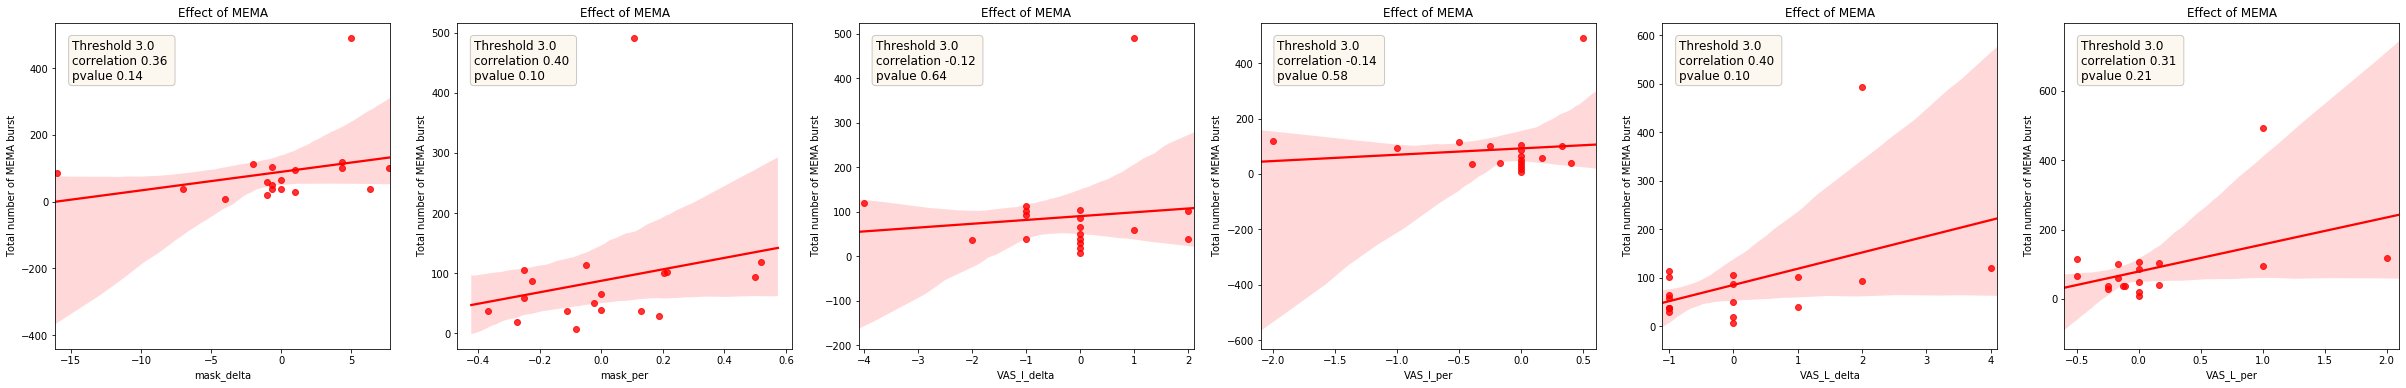

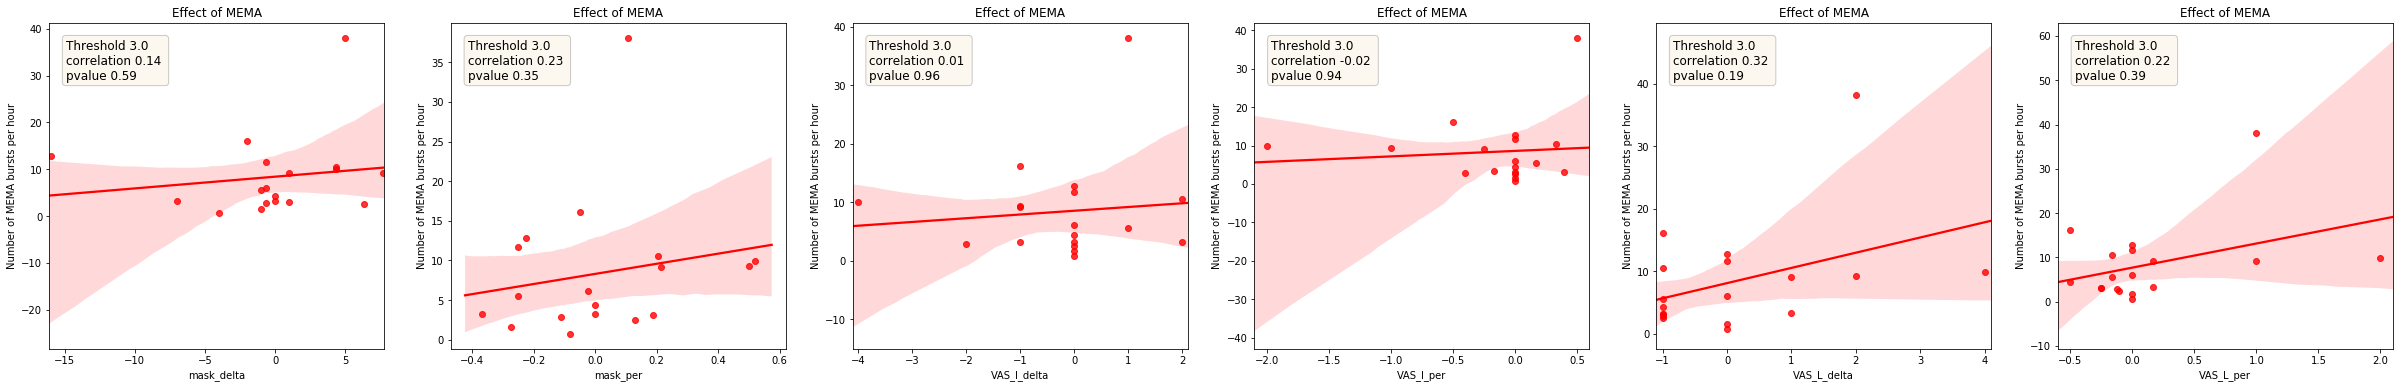

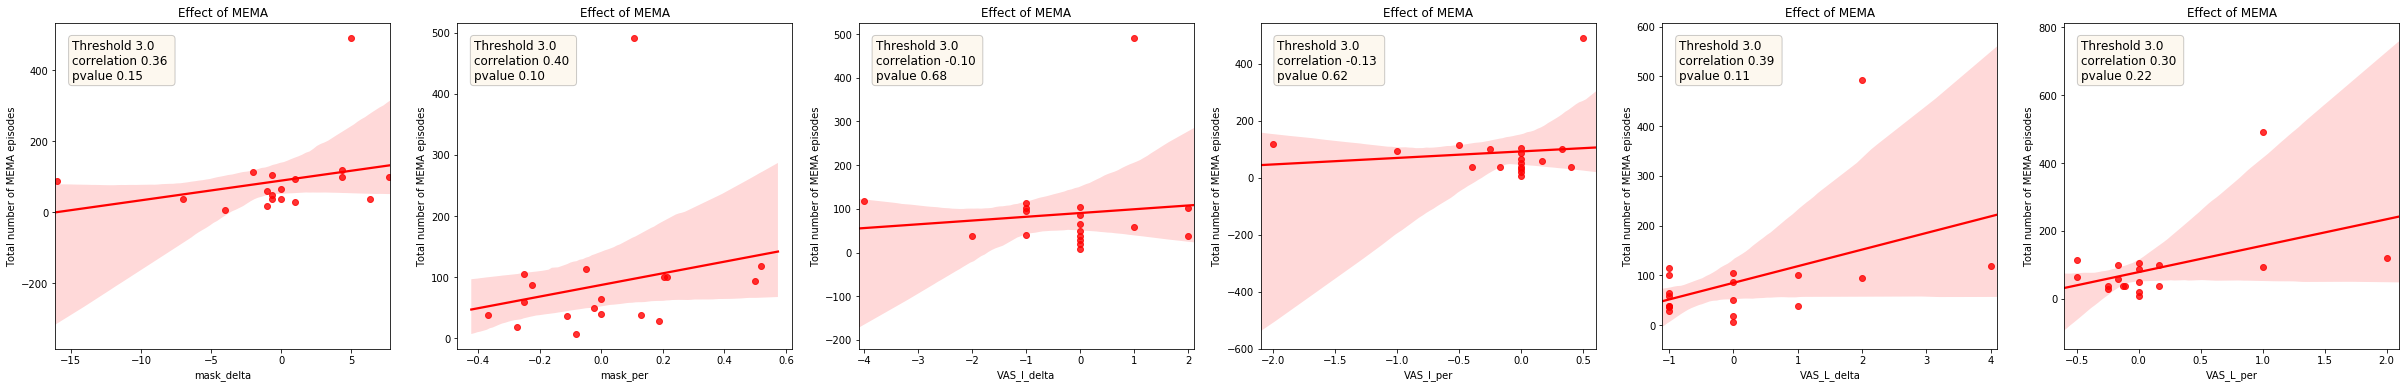

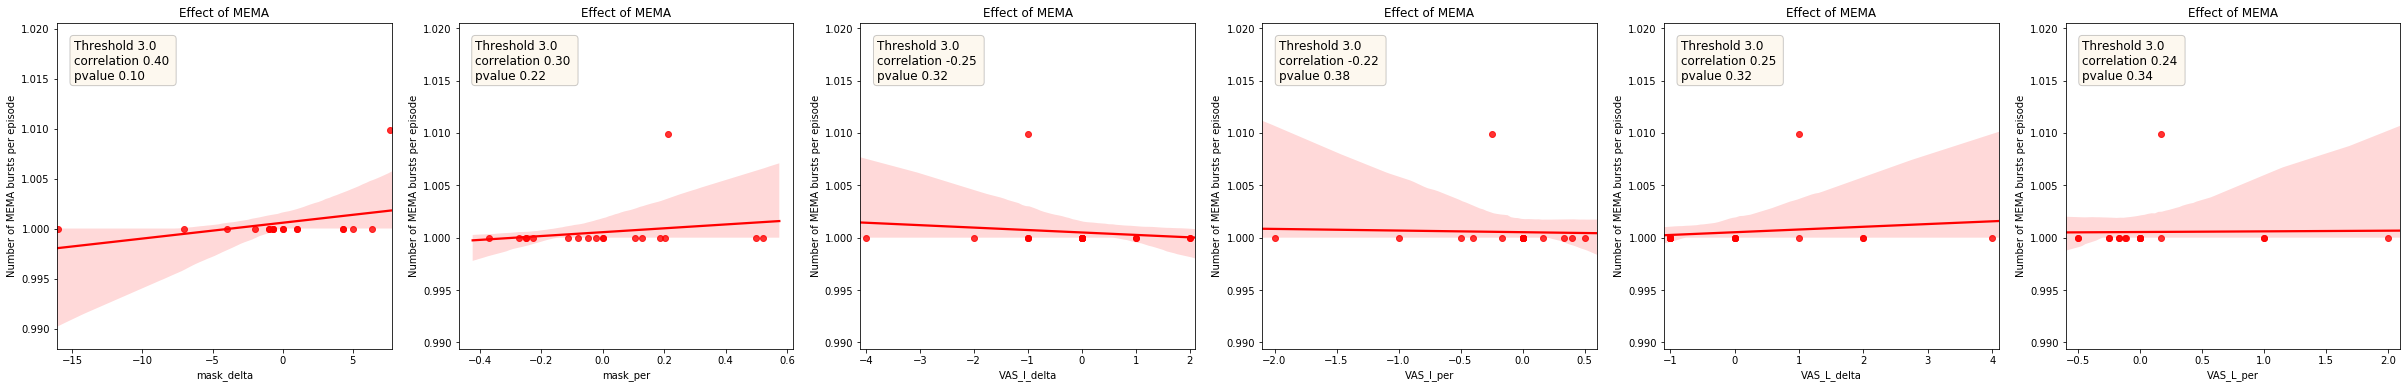

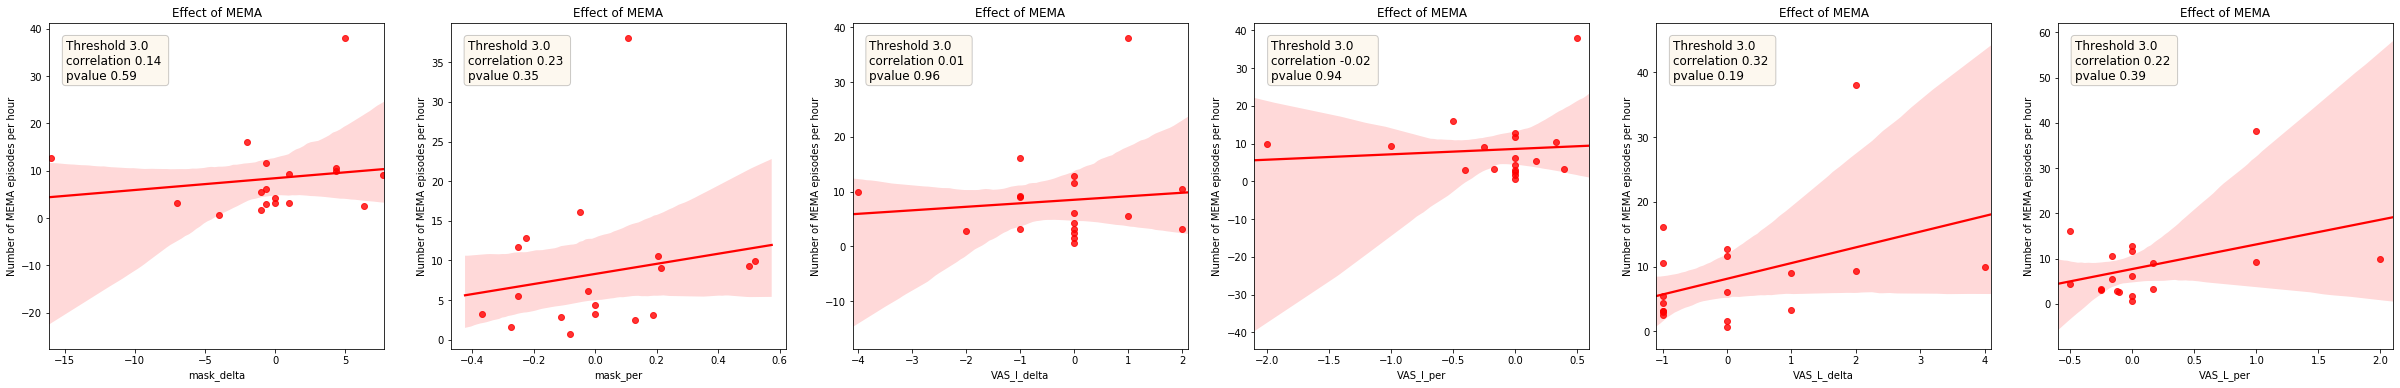

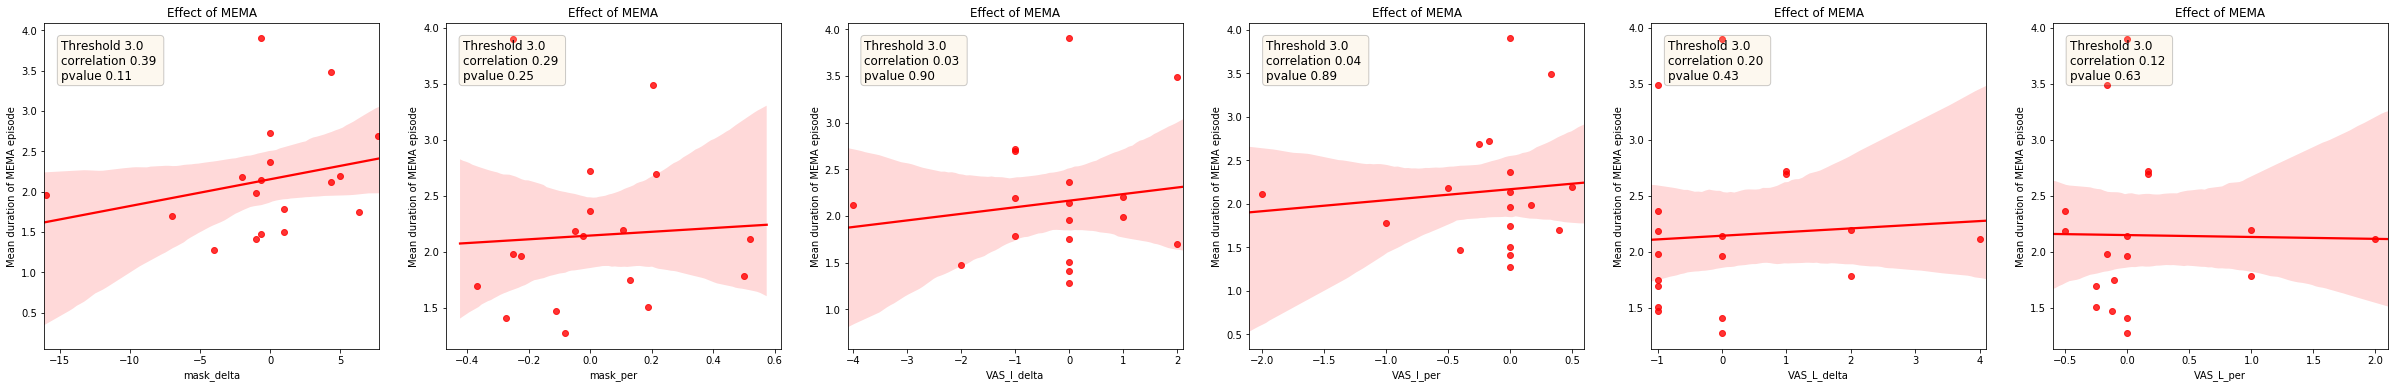

In [32]:
meta_results = pd.DataFrame()
import seaborn as sns
plt.close("all")
data = reports.query("category != 'control'")
# loop over all quantitative variables (y_axis)
for y_axis in quantitative_variables:
    # loop on all classification results (each figure)
    for threshold in reports["THR_classif"].unique():
        data_loc = data[data["THR_classif"]==threshold]
        f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 6))
        # loop on all effect variables (each subplot)
        for x_axis, ax in zip(effect_variable, axes):
            
            regression_result = scipy.stats.spearmanr(data_loc[x_axis].values,data_loc[y_axis].values)
            if regression_result.pvalue < 0.01:
                    color = 'g'
            elif regression_result.pvalue < 0.05:
                    color = 'b'
            else:
                    color = 'r'
            sns.regplot(x=x_axis,y=y_axis,data=data_loc,fit_reg=True, ax=ax,  color=color)
            ax.set_xlim(min(data_loc[x_axis].values)-0.1,max(data_loc[x_axis].values)+0.1)
            tmp = {"x_axis":x_axis, "y_axis":y_axis, "THR_classif": [threshold]}
            textstr = f"Threshold {threshold:.1f} "
            for a, re in zip(regression_result._fields, regression_result):
                textstr = textstr + "\n" + f"{a} {re:.2f} "
                tmp[a] = [re]
            ax.set_title("Effect of MEMA")
            # place patch
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
                    verticalalignment='top', bbox=props)
            
            # save results
            meta_results = pd.concat([meta_results, pd.DataFrame(tmp)])

In [33]:
meta_results.query("pvalue < 0.05")

,x_axis,y_axis,THR_classif,correlation,pvalue


etiology (?) : 6, ['1DA15', '1GB18', '1HB20', '1SL21', '1UC22', '1ZN04']
etiology (group1) : 7, ['1HS25', '1PA31', '1RF29', '1GF14', '1DM32', '1NS30', '1AC26']
etiology (group3) : 6, ['3NS01', '3BS04', '3TR07', '3KB06', '3TS03', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

?_3 v.s. group1_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.519e-01 U_stat=2.900e+01
group1_3 v.s. group3_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.300e+01
?_3 v.s. group3_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.846e-01 U_stat=2.800e+01


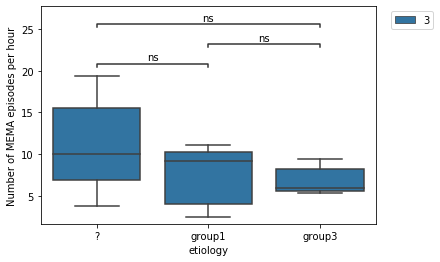

obstructed_ear (False) : 8, ['1DA15', '1HB20', '1HS25', '1RF29', '3TR07', '3KB06', '3TS03', '3HS08']
obstructed_ear (True) : 11, ['1GB18', '1SL21', '1UC22', '1ZN04', '1PA31', '3NS01', '1GF14', '1DM32', '3BS04', '1NS30', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.312e-01 U_stat=2.900e+01


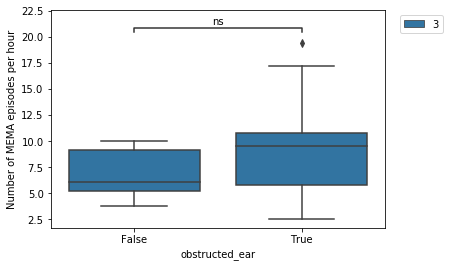

otalgy (False) : 15, ['1DA15', '1GB18', '1HB20', '1SL21', '1UC22', '1ZN04', '1HS25', '3NS01', '1RF29', '1GF14', '3BS04', '3TR07', '3KB06', '1NS30', '3TS03']
otalgy (True) : 4, ['1PA31', '1DM32', '1AC26', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.263e-01 U_stat=3.400e+01


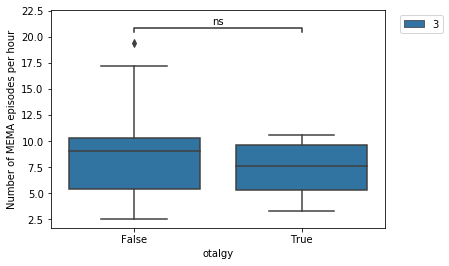

hyperacusis (True) : 9, ['1DA15', '1ZN04', '1PA31', '1RF29', '1GF14', '1DM32', '3KB06', '3TS03', '3HS08']
hyperacusis (False) : 10, ['1GB18', '1HB20', '1SL21', '1UC22', '1HS25', '3NS01', '3BS04', '3TR07', '1NS30', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.779e-01 U_stat=6.200e+01


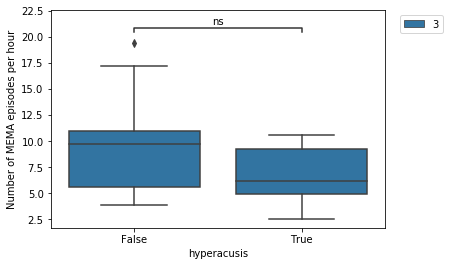

jaw_popping (True) : 11, ['1DA15', '1SL21', '1ZN04', '1HS25', '1PA31', '3NS01', '1GF14', '1DM32', '3BS04', '1NS30', '3HS08']
jaw_popping (False) : 8, ['1GB18', '1HB20', '1UC22', '1RF29', '3TR07', '3KB06', '1AC26', '3TS03']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.497e-01 U_stat=5.000e+01


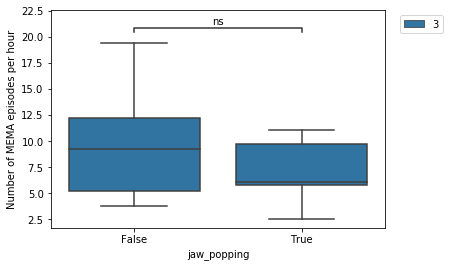

jaw_pain_and_fatigue (False) : 14, ['1DA15', '1GB18', '1HB20', '1SL21', '1UC22', '1ZN04', '3NS01', '1RF29', '1GF14', '3TR07', '3KB06', '1NS30', '3TS03', '3HS08']
jaw_pain_and_fatigue (True) : 5, ['1HS25', '1PA31', '1DM32', '3BS04', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.896e-01 U_stat=3.700e+01


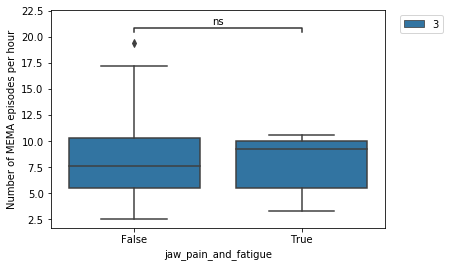

somatosensory_modulation (False) : 12, ['1DA15', '1GB18', '1HB20', '1SL21', '1ZN04', '3NS01', '1RF29', '1DM32', '3KB06', '1NS30', '3TS03', '3HS08']
somatosensory_modulation (True) : 7, ['1UC22', '1HS25', '1PA31', '1GF14', '3BS04', '3TR07', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.262e-01 U_stat=5.000e+01


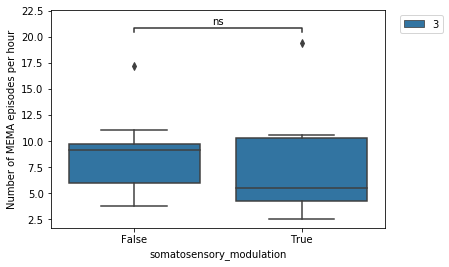

nap_modulation (False) : 14, ['1DA15', '1GB18', '1ZN04', '1PA31', '3NS01', '1GF14', '1DM32', '3BS04', '3TR07', '3KB06', '1NS30', '1AC26', '3TS03', '3HS08']
nap_modulation (True) : 5, ['1HB20', '1SL21', '1UC22', '1HS25', '1RF29']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.170e-01 U_stat=3.200e+01


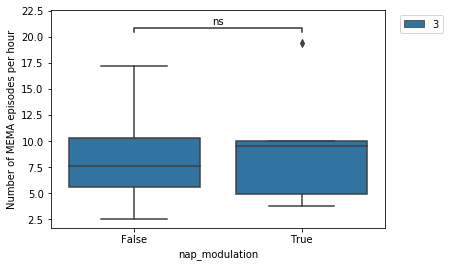

snoring (False) : 12, ['1DA15', '1GB18', '1ZN04', '1HS25', '3NS01', '1GF14', '1DM32', '3BS04', '3TR07', '1NS30', '3TS03', '3HS08']
snoring (True) : 7, ['1HB20', '1SL21', '1UC22', '1PA31', '1RF29', '3KB06', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.991e-01 U_stat=4.400e+01


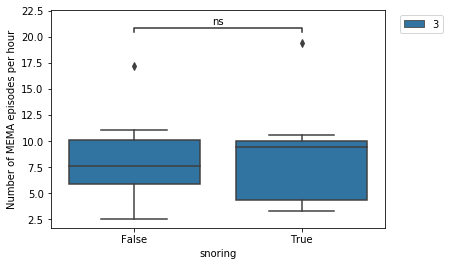

neck_pain (True) : 12, ['1DA15', '1HB20', '1HS25', '1PA31', '3NS01', '1RF29', '1GF14', '1DM32', '3BS04', '3KB06', '1AC26', '3TS03']
neck_pain (False) : 7, ['1GB18', '1SL21', '1UC22', '1ZN04', '3TR07', '1NS30', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.115e-02 U_stat=6.800e+01


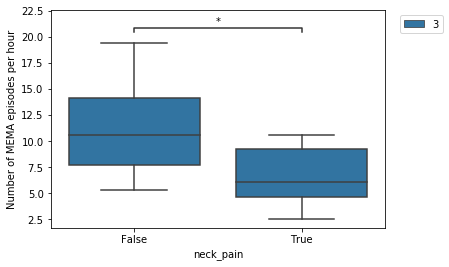

trauma_sonore (True) : 6, ['1DA15', '1GB18', '1UC22', '3TR07', '1NS30', '3HS08']
trauma_sonore (False) : 13, ['1HB20', '1SL21', '1ZN04', '1HS25', '1PA31', '3NS01', '1RF29', '1GF14', '1DM32', '3BS04', '3KB06', '1AC26', '3TS03']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.740e-01 U_stat=2.300e+01


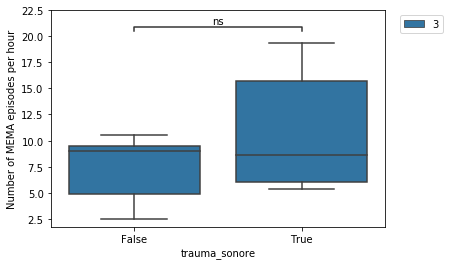

otite (False) : 10, ['1DA15', '1HS25', '3NS01', '1DM32', '3BS04', '3TR07', '3KB06', '1NS30', '3TS03', '3HS08']
otite (True) : 9, ['1GB18', '1HB20', '1SL21', '1UC22', '1ZN04', '1PA31', '1RF29', '1GF14', '1AC26']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.674e-01 U_stat=4.400e+01


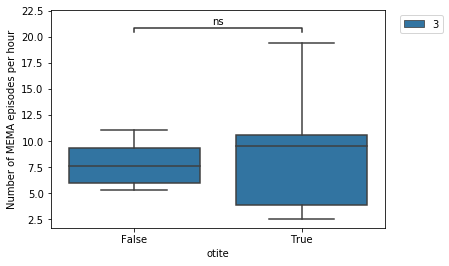

Ear clapping (False) : 8, ['1DA15', '1HB20', '1SL21', '1HS25', '1DM32', '3BS04', '3TR07', '3KB06']
Ear clapping (True) : 11, ['1GB18', '1UC22', '1ZN04', '1PA31', '3NS01', '1RF29', '1GF14', '1NS30', '1AC26', '3TS03', '3HS08']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

False_3 v.s. True_3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.915e-01 U_stat=3.700e+01


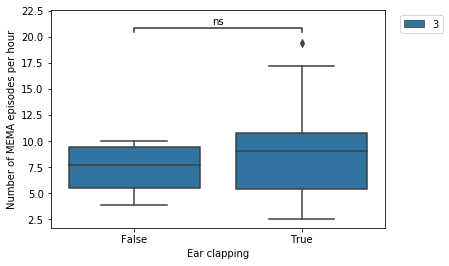

In [40]:
# e.1 GROUP BY ETIOLOGIES
plt.close("all")
from tinnsleep.visualization import etiology_report_with_plot

data = reports.query("category != 'control'")
variable = "Number of MEMA episodes per hour"
#variable = 'Total number of MEMA episodes'

hue = "THR_classif"
threshold = 3

etiologies = ['etiology', 'obstructed_ear', 'otalgy', 'hyperacusis', 'jaw_popping', 'jaw_pain_and_fatigue', 
            'somatosensory_modulation', 'nap_modulation', 'snoring', "neck_pain", "trauma_sonore", "otite",
             "Ear clapping"]

for etiology in etiologies:
    etiology_report_with_plot(data, etiology, variable, hue=hue, hue_value_for_stats=threshold)
    plt.show()
    

In [24]:
from scipy import signal

x = np.array([0,1,0.5,0,1,0])
x = [0,0,0.5,0,1, 2,1 , 0]
get_it = scipy.signal.find_peaks(x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)
print(get_it)
print(scipy.signal.peak_prominences(x, get_it[0]))
print(file_side)
print(len(results_MEMA[file_side]["reports"][0]["peaks"]))
print(results_MEMA[file_side]["reports"][0])


(array([2, 5], dtype=int64), {})
(array([0.5, 2. ]), array([1, 3], dtype=int64), array([3, 7], dtype=int64))
1AC26_cohort2.edf_right
551
{'Clean MEMA duration': 23998.464, 'Total MEMA burst duration': 546.592, 'Total number of MEMA burst': 253, 'Number of MEMA bursts per hour': 37.95242895545315, 'MEMA episode NREM count': 158, 'MEMA episode NREM ratio': 1.0, 'Total number of MEMA episodes': 158, 'Number of MEMA bursts per episode': 1.6012658227848102, 'Number of MEMA episodes per hour': 23.70151689708141, 'Mean duration of MEMA episode': 4.332151898734249, 'End count': 7, 'End ratio': 0.00020139248518326715, 'NREM count': 24279, 'NREM ratio': 0.698515449680649, 'Wake count': 10449, 'Wake ratio': 0.3006214396685655, 'start count': 23, 'start ratio': 0.0006617181656021635, 'Power Ratio': array([18.05800538]), 'peaks': [[(array([ 22,  39,  56,  77,  93, 109, 124, 149, 170, 185, 201, 226, 240],
      dtype=int64), {}), (array([1.78247230e-03, 1.42944003e-06, 1.26822417e-02, 2.90475847e-03

Traceback (most recent call last):
  File "C:\Users\robin\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 224, in process
    func(*args, **kwargs)
  File "C:\Users\robin\anaconda3\lib\site-packages\mne\viz\_figure.py", line 716, in _keypress
    self._show_vline(None)
  File "C:\Users\robin\anaconda3\lib\site-packages\mne\viz\_figure.py", line 2184, in _show_vline
    self.mne.vline_text.set_text(f'{xdata:0.2f}  ')
TypeError: unsupported format string passed to NoneType.__format__
Traceback (most recent call last):
  File "C:\Users\robin\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 224, in process
    func(*args, **kwargs)
  File "C:\Users\robin\anaconda3\lib\site-packages\mne\viz\_figure.py", line 716, in _keypress
    self._show_vline(None)
  File "C:\Users\robin\anaconda3\lib\site-packages\mne\viz\_figure.py", line 2184, in _show_vline
    self.mne.vline_text.set_text(f'{xdata:0.2f}  ')
TypeError: unsupported format string passed to NoneType.__for

Channels marked as bad: none
Channels marked as bad: none
Channels marked as bad: none
